In [ ]:
#@title Pre modelling step (building the dataframe to be used in the modelling process)


In [ ]:
import numpy as np
import pandas as pd
import datetime as dt 
import matplotlib.pyplot as plt
from numpy import percentile
import seaborn as sns

In [ ]:
# We upload the excel file
from google.colab import files
uploaded = files.upload()

Saving 10259_after_outlier_removal& Imputation.xlsx to 10259_after_outlier_removal& Imputation (1).xlsx


In [ ]:
# Convert the excel file into pandas Dataframe
import io 
df = pd.read_excel(io.BytesIO(uploaded['10259_after_outlier_removal& Imputation.xlsx']))
# We round the columns (POWER , Temperature, Irradiation.flux) to one decimal place.
df['Temperature']=df['Temperature'].round(1)
df['Irradiation.flux']=df['Irradiation.flux'].round(1)





In [ ]:
# After creating the new dataframe (called dk), we link it to calendar data table  which is put in an excel file to carry out this step :  
# We download the calendar data excel file
from google.colab import files
uploaded = files.upload()

Saving calendar Data .xlsx to calendar Data  (1).xlsx


In [ ]:
# Convert the excel file into Dataframe
import io 
cal = pd.read_excel(io.BytesIO(uploaded['calendar Data .xlsx']))
#In the "Bank Holidays" column we replace the NaN value with zeros.
cal['Bank Holidays'] = cal['Bank Holidays'].fillna(0)
# we remove the "READ_DATE" and "Week_Day" columns to avoid the Repetition of these column when linking it to the dataframe "Dk" 
remove_column = cal.pop('READ_DATE')
remove2_column = cal.pop('Week_Day')


In [ ]:
#we join the calendar dataframe with the original dataset (10259_after_outlier_removal& Imputation)

df_cal = pd.concat([df,cal], axis=1, join='inner')
df_cal = df_cal[24:]   # Delete the first 24 rows
df_cal.shape


(8736, 181)

In [ ]:
# We create multiple POWER lagged columns (we choose 12 lagged dependent variables  ) 
lagged1 = pd.concat([df['POWER1'].shift(lag).rename('{}_lag{}'.format(df['POWER1'].name, lag)) for lag in range(13)], axis=1)
# we convert the integers to float using astype fuction  and drop the the nan values using dropna function.
L1=lagged1.dropna().astype(float)


In [ ]:
# We create multiple Temperature lagged columns (we choose 24 lagged independent variables)
lagged2 = pd.concat([df['Temperature'].shift(lag).rename('{}_lag{}'.format(df['Temperature'].name, lag)) for lag in range(25)], axis=1)
# we convert the integers to float using astype fuction  and drop the the nan values usiing dropna function.
L2=lagged2.dropna().astype(float)


In [ ]:
# We create multiple Irradiation.flux lagged columns(we choose 24 lagged independent variables)
lagged3 = pd.concat([df['Irradiation.flux'].shift(lag).rename('{}_lag{}'.format(df['Irradiation.flux'].name, lag)) for lag in range(25)], axis=1)
# we convert the integers to float using astype fuction  and drop the the nan values usiing dropna function.
L3=lagged3.dropna().astype(float)



In [ ]:
# Maximize the size of Column in google colab 
#(we resize the maximum number of columns in google colab to fit our dataframe)
from google.colab.data_table import DataTable
DataTable.max_columns = 300
# Joining the DataFrame of POWER Lagged Columns to the Dataframe of Temperature Lagged Columns 
# We use the concat function to join 2 dataframes lagged1 (POWER) + lagged2 (Temperature) => Creation of new dataframe called "result".
result = pd.concat([L1,L2], axis=1, join='inner')

In [ ]:
#Joining the DataFrame of POWER and Temperature Lagged Columns (POWER+Temperature=> result dataframe) to the Dataframe of Irradiation flux Lagged Columns 
# We use the concat function to join 2 dataframes result (POWER+Temperature) + lagged3 (Irradiation flux)  => Creation of new dataframe called "result1"
result1 = pd.concat([result,L3], axis=1, join='inner')


In [ ]:
# We join the "Result1" Dataframe (Power , Temperature, Irradiation flux ) to the  dataframe (df_cal)
result2 = pd.concat([df_cal,result1], axis=1, join='inner')



In [ ]:
# we extract the winter term Months to build our model. 
winter_model=result2[(result2['Month'] == 12) | (result2['Month'] == 1)| (result2['Month'] == 2)]
# we reset the indices
winter_model.reset_index(inplace = True)
winter_model= winter_model.drop(['index'], axis=1)


In [ ]:
# In order to remove the weekly seasonality we will split the dataframe into Working days and weekend. 
#Therefore we will have 2 model for the winter term. (one for the working day and the other for the weekend)
#We start with the working day (Monday to Friday)
working_day_model=winter_model[(winter_model['Week_Day'] == 'MON') | (winter_model['Week_Day'] == 'TUE')| (winter_model['Week_Day'] == 'WED')|(winter_model['Week_Day'] == 'THU')|(winter_model['Week_Day'] == 'FRI')]


In [ ]:
# We split the dataset into training and testing data.
# we filter the dataset into odd and even days (the even days will represent the testing data  )
testing_data=working_day_model[working_day_model.Day_month % 2==0]


In [ ]:
# the odd days will represent the training data.
training_data=working_day_model[working_day_model.Day_month % 2==1]


In [ ]:
# we convert the  integers dummy variables (calendar data)  to floats. (training_data dataframe)
training_data[['Tuesday 0h','Tuesday 1h','Tuesday 2h','Tuesday 3h','Tuesday 4h','Tuesday 5h','Tuesday 6h','Tuesday 7h','Tuesday 8h','Tuesday 9h','Tuesday 10h','Tuesday 11h','Tuesday 12h','Tuesday 13h','Tuesday 14h',
        'Tuesday 15h','Tuesday 16h','Tuesday 17h','Tuesday 18h','Tuesday 19h','Tuesday 20h','Tuesday 21h','Tuesday 22h','Tuesday 23h','Wednesday 0h','Wednesday 1h','Wednesday 2h','Wednesday 3h','Wednesday 4h','Wednesday 5h','Wednesday 6h','Wednesday 7h','Wednesday 8h','Wednesday 9h','Wednesday 10h','Wednesday 11h','Wednesday 12h','Wednesday 13h','Wednesday 14h',
        'Wednesday 15h','Wednesday 16h','Wednesday 17h','Wednesday 18h','Wednesday 19h','Wednesday 20h','Wednesday 21h','Wednesday 22h','Wednesday 23h','Thursday 0h','Thursday 1h','Thursday 2h','Thursday 3h','Thursday 4h','Thursday 5h','Thursday 6h','Thursday 7h','Thursday 8h','Thursday 9h','Thursday 10h','Thursday 11h','Thursday 12h','Thursday 13h','Thursday 14h',
        'Thursday 15h','Thursday 16h','Thursday 17h','Thursday 18h','Thursday 19h','Thursday 20h','Thursday 21h','Thursday 22h','Thursday 23h','Friday 0h','Friday 1h','Friday 2h','Friday 3h','Friday 4h','Friday 5h','Friday 6h','Friday 7h','Friday 8h','Friday 9h','Friday 10h','Friday 11h','Friday 12h','Friday 13h','Friday 14h',
        'Friday 15h','Friday 16h','Friday 17h','Friday 18h','Friday 19h','Friday 20h','Friday 21h','Friday 22h','Friday 23h','Saturday 0h','Saturday 1h','Saturday 2h','Saturday 3h','Saturday 4h','Saturday 5h','Saturday 6h','Saturday 7h','Saturday 8h','Saturday 9h','Saturday 10h','Saturday 11h','Saturday 12h','Saturday 13h','Saturday 14h',
        'Saturday 15h','Saturday 16h','Saturday 17h','Saturday 18h','Saturday 19h','Saturday 20h','Saturday 21h','Saturday 22h','Saturday 23h','Sunday 0h','Sunday 1h','Sunday 2h','Sunday 3h','Sunday 4h','Sunday 5h','Sunday 6h','Sunday 7h','Sunday 8h','Sunday 9h','Sunday 10h','Sunday 11h','Sunday 12h','Sunday 13h','Sunday 14h',
        'Sunday 15h','Sunday 16h','Sunday 17h','Sunday 18h','Sunday 19h','Sunday 20h','Sunday 21h','Sunday 22h','Sunday 23h','Monday 0h','Monday 1h','Monday 2h','Monday 3h','Monday 4h','Monday 5h','Monday 6h','Monday 7h','Monday 8h','Monday 9h','Monday 10h','Monday 11h','Monday 12h','Monday 13h','Monday 14h',
        'Monday 15h','Monday 16h','Monday 17h','Monday 18h','Monday 19h','Monday 20h','Monday 21h','Monday 22h','Monday 23h']]= training_data[['Tuesday 0h','Tuesday 1h','Tuesday 2h','Tuesday 3h','Tuesday 4h','Tuesday 5h','Tuesday 6h','Tuesday 7h','Tuesday 8h','Tuesday 9h','Tuesday 10h','Tuesday 11h','Tuesday 12h','Tuesday 13h','Tuesday 14h',
        'Tuesday 15h','Tuesday 16h','Tuesday 17h','Tuesday 18h','Tuesday 19h','Tuesday 20h','Tuesday 21h','Tuesday 22h','Tuesday 23h','Wednesday 0h','Wednesday 1h','Wednesday 2h','Wednesday 3h','Wednesday 4h','Wednesday 5h','Wednesday 6h','Wednesday 7h','Wednesday 8h','Wednesday 9h','Wednesday 10h','Wednesday 11h','Wednesday 12h','Wednesday 13h','Wednesday 14h',
        'Wednesday 15h','Wednesday 16h','Wednesday 17h','Wednesday 18h','Wednesday 19h','Wednesday 20h','Wednesday 21h','Wednesday 22h','Wednesday 23h','Thursday 0h','Thursday 1h','Thursday 2h','Thursday 3h','Thursday 4h','Thursday 5h','Thursday 6h','Thursday 7h','Thursday 8h','Thursday 9h','Thursday 10h','Thursday 11h','Thursday 12h','Thursday 13h','Thursday 14h',
        'Thursday 15h','Thursday 16h','Thursday 17h','Thursday 18h','Thursday 19h','Thursday 20h','Thursday 21h','Thursday 22h','Thursday 23h','Friday 0h','Friday 1h','Friday 2h','Friday 3h','Friday 4h','Friday 5h','Friday 6h','Friday 7h','Friday 8h','Friday 9h','Friday 10h','Friday 11h','Friday 12h','Friday 13h','Friday 14h',
        'Friday 15h','Friday 16h','Friday 17h','Friday 18h','Friday 19h','Friday 20h','Friday 21h','Friday 22h','Friday 23h','Saturday 0h','Saturday 1h','Saturday 2h','Saturday 3h','Saturday 4h','Saturday 5h','Saturday 6h','Saturday 7h','Saturday 8h','Saturday 9h','Saturday 10h','Saturday 11h','Saturday 12h','Saturday 13h','Saturday 14h',
        'Saturday 15h','Saturday 16h','Saturday 17h','Saturday 18h','Saturday 19h','Saturday 20h','Saturday 21h','Saturday 22h','Saturday 23h','Sunday 0h','Sunday 1h','Sunday 2h','Sunday 3h','Sunday 4h','Sunday 5h','Sunday 6h','Sunday 7h','Sunday 8h','Sunday 9h','Sunday 10h','Sunday 11h','Sunday 12h','Sunday 13h','Sunday 14h',
        'Sunday 15h','Sunday 16h','Sunday 17h','Sunday 18h','Sunday 19h','Sunday 20h','Sunday 21h','Sunday 22h','Sunday 23h','Monday 0h','Monday 1h','Monday 2h','Monday 3h','Monday 4h','Monday 5h','Monday 6h','Monday 7h','Monday 8h','Monday 9h','Monday 10h','Monday 11h','Monday 12h','Monday 13h','Monday 14h',
        'Monday 15h','Monday 16h','Monday 17h','Monday 18h','Monday 19h','Monday 20h','Monday 21h','Monday 22h','Monday 23h']].apply(pd.to_numeric,downcast='float')


training_data.dtypes


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


READ_DATE                 datetime64[ns]
Day                                int64
Day_month                          int64
Month                              int64
Year                               int64
                               ...      
Irradiation.flux_lag20           float64
Irradiation.flux_lag21           float64
Irradiation.flux_lag22           float64
Irradiation.flux_lag23           float64
Irradiation.flux_lag24           float64
Length: 244, dtype: object

In [ ]:
# we convert the  integers dummy variables (calendar data)  to floats. (testing_data dataframe)
testing_data[['Tuesday 0h','Tuesday 1h','Tuesday 2h','Tuesday 3h','Tuesday 4h','Tuesday 5h','Tuesday 6h','Tuesday 7h','Tuesday 8h','Tuesday 9h','Tuesday 10h','Tuesday 11h','Tuesday 12h','Tuesday 13h','Tuesday 14h',
        'Tuesday 15h','Tuesday 16h','Tuesday 17h','Tuesday 18h','Tuesday 19h','Tuesday 20h','Tuesday 21h','Tuesday 22h','Tuesday 23h','Wednesday 0h','Wednesday 1h','Wednesday 2h','Wednesday 3h','Wednesday 4h','Wednesday 5h','Wednesday 6h','Wednesday 7h','Wednesday 8h','Wednesday 9h','Wednesday 10h','Wednesday 11h','Wednesday 12h','Wednesday 13h','Wednesday 14h',
        'Wednesday 15h','Wednesday 16h','Wednesday 17h','Wednesday 18h','Wednesday 19h','Wednesday 20h','Wednesday 21h','Wednesday 22h','Wednesday 23h','Thursday 0h','Thursday 1h','Thursday 2h','Thursday 3h','Thursday 4h','Thursday 5h','Thursday 6h','Thursday 7h','Thursday 8h','Thursday 9h','Thursday 10h','Thursday 11h','Thursday 12h','Thursday 13h','Thursday 14h',
        'Thursday 15h','Thursday 16h','Thursday 17h','Thursday 18h','Thursday 19h','Thursday 20h','Thursday 21h','Thursday 22h','Thursday 23h','Friday 0h','Friday 1h','Friday 2h','Friday 3h','Friday 4h','Friday 5h','Friday 6h','Friday 7h','Friday 8h','Friday 9h','Friday 10h','Friday 11h','Friday 12h','Friday 13h','Friday 14h',
        'Friday 15h','Friday 16h','Friday 17h','Friday 18h','Friday 19h','Friday 20h','Friday 21h','Friday 22h','Friday 23h','Saturday 0h','Saturday 1h','Saturday 2h','Saturday 3h','Saturday 4h','Saturday 5h','Saturday 6h','Saturday 7h','Saturday 8h','Saturday 9h','Saturday 10h','Saturday 11h','Saturday 12h','Saturday 13h','Saturday 14h',
        'Saturday 15h','Saturday 16h','Saturday 17h','Saturday 18h','Saturday 19h','Saturday 20h','Saturday 21h','Saturday 22h','Saturday 23h','Sunday 0h','Sunday 1h','Sunday 2h','Sunday 3h','Sunday 4h','Sunday 5h','Sunday 6h','Sunday 7h','Sunday 8h','Sunday 9h','Sunday 10h','Sunday 11h','Sunday 12h','Sunday 13h','Sunday 14h',
        'Sunday 15h','Sunday 16h','Sunday 17h','Sunday 18h','Sunday 19h','Sunday 20h','Sunday 21h','Sunday 22h','Sunday 23h','Monday 0h','Monday 1h','Monday 2h','Monday 3h','Monday 4h','Monday 5h','Monday 6h','Monday 7h','Monday 8h','Monday 9h','Monday 10h','Monday 11h','Monday 12h','Monday 13h','Monday 14h',
        'Monday 15h','Monday 16h','Monday 17h','Monday 18h','Monday 19h','Monday 20h','Monday 21h','Monday 22h','Monday 23h']]= testing_data[['Tuesday 0h','Tuesday 1h','Tuesday 2h','Tuesday 3h','Tuesday 4h','Tuesday 5h','Tuesday 6h','Tuesday 7h','Tuesday 8h','Tuesday 9h','Tuesday 10h','Tuesday 11h','Tuesday 12h','Tuesday 13h','Tuesday 14h',
        'Tuesday 15h','Tuesday 16h','Tuesday 17h','Tuesday 18h','Tuesday 19h','Tuesday 20h','Tuesday 21h','Tuesday 22h','Tuesday 23h','Wednesday 0h','Wednesday 1h','Wednesday 2h','Wednesday 3h','Wednesday 4h','Wednesday 5h','Wednesday 6h','Wednesday 7h','Wednesday 8h','Wednesday 9h','Wednesday 10h','Wednesday 11h','Wednesday 12h','Wednesday 13h','Wednesday 14h',
        'Wednesday 15h','Wednesday 16h','Wednesday 17h','Wednesday 18h','Wednesday 19h','Wednesday 20h','Wednesday 21h','Wednesday 22h','Wednesday 23h','Thursday 0h','Thursday 1h','Thursday 2h','Thursday 3h','Thursday 4h','Thursday 5h','Thursday 6h','Thursday 7h','Thursday 8h','Thursday 9h','Thursday 10h','Thursday 11h','Thursday 12h','Thursday 13h','Thursday 14h',
        'Thursday 15h','Thursday 16h','Thursday 17h','Thursday 18h','Thursday 19h','Thursday 20h','Thursday 21h','Thursday 22h','Thursday 23h','Friday 0h','Friday 1h','Friday 2h','Friday 3h','Friday 4h','Friday 5h','Friday 6h','Friday 7h','Friday 8h','Friday 9h','Friday 10h','Friday 11h','Friday 12h','Friday 13h','Friday 14h',
        'Friday 15h','Friday 16h','Friday 17h','Friday 18h','Friday 19h','Friday 20h','Friday 21h','Friday 22h','Friday 23h','Saturday 0h','Saturday 1h','Saturday 2h','Saturday 3h','Saturday 4h','Saturday 5h','Saturday 6h','Saturday 7h','Saturday 8h','Saturday 9h','Saturday 10h','Saturday 11h','Saturday 12h','Saturday 13h','Saturday 14h',
        'Saturday 15h','Saturday 16h','Saturday 17h','Saturday 18h','Saturday 19h','Saturday 20h','Saturday 21h','Saturday 22h','Saturday 23h','Sunday 0h','Sunday 1h','Sunday 2h','Sunday 3h','Sunday 4h','Sunday 5h','Sunday 6h','Sunday 7h','Sunday 8h','Sunday 9h','Sunday 10h','Sunday 11h','Sunday 12h','Sunday 13h','Sunday 14h',
        'Sunday 15h','Sunday 16h','Sunday 17h','Sunday 18h','Sunday 19h','Sunday 20h','Sunday 21h','Sunday 22h','Sunday 23h','Monday 0h','Monday 1h','Monday 2h','Monday 3h','Monday 4h','Monday 5h','Monday 6h','Monday 7h','Monday 8h','Monday 9h','Monday 10h','Monday 11h','Monday 12h','Monday 13h','Monday 14h',
        'Monday 15h','Monday 16h','Monday 17h','Monday 18h','Monday 19h','Monday 20h','Monday 21h','Monday 22h','Monday 23h']].apply(pd.to_numeric,downcast='float')


testing_data.dtypes

READ_DATE                 datetime64[ns]
Day                                int64
Day_month                          int64
Month                              int64
Year                               int64
                               ...      
Irradiation.flux_lag20           float64
Irradiation.flux_lag21           float64
Irradiation.flux_lag22           float64
Irradiation.flux_lag23           float64
Irradiation.flux_lag24           float64
Length: 244, dtype: object

In [ ]:
#@title ARX model (Workdays)


In [ ]:
#Separation of indeppendent variables and dependent variables

import pandas as pd
import statsmodels.api as sm
X = training_data[['POWER1_lag1','POWER1_lag2','POWER1_lag3','Temperature_lag0','Temperature_lag1','Irradiation.flux_lag0','Monday 8h','Tuesday 1h','Wednesday 3h','Wednesday 7h','Friday 5h']] 
Y = training_data['POWER1_lag0']

In [ ]:
# we fit our model using the ols method . 
import pandas as pd
import statsmodels.api as sm
from sklearn import linear_model
import statsmodels.formula.api as smf
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            POWER1_lag0   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     349.4
Date:                Thu, 01 Dec 2022   Prob (F-statistic):          1.34e-287
Time:                        12:36:00   Log-Likelihood:                -1727.4
No. Observations:                 768   AIC:                             3479.
Df Residuals:                     756   BIC:                             3535.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.73

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#@title  Data Scenarios and Model optimization to predict the heat   load    (workdays)



In [ ]:
# We evaluate the performance of models using the three different data scenarios


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
F=testing_data.rename(columns={'Tuesday 0h':'Tuesday_0h','Tuesday 1h':'Tuesday_1h','Tuesday 2h':'Tuesday_2h','Tuesday 3h':'Tuesday_3h','Tuesday 4h':'Tuesday_4h','Tuesday 5h':'Tuesday_5h','Tuesday 6h':'Tuesday_6h','Tuesday 7h':'Tuesday_7h','Tuesday 8h':'Tuesday_8h','Tuesday 9h':'Tuesday_9h','Tuesday 10h':'Tuesday_10h','Tuesday 11h':'Tuesday_11h','Tuesday 12h':'Tuesday_12h','Tuesday 13h':'Tuesday_13h','Tuesday 14h':'Tuesday_14h',
'Tuesday 15h':'Tuesday_15h','Tuesday 16h':'Tuesday_16h','Tuesday 17h':'Tuesday_17h','Tuesday 18h':'Tuesday_18h','Tuesday 19h':'Tuesday_19h','Tuesday 20h':'Tuesday_20h','Tuesday 21h':'Tuesday_21h','Tuesday 22h':'Tuesday_22h','Tuesday 23h':'Tuesday_23h','Wednesday 0h':'Wednesday_0h','Wednesday 1h':'Wednesday_1h','Wednesday 2h':'Wednesday_2h','Wednesday 3h':'Wednesday_3h','Wednesday 4h':'Wednesday_4h','Wednesday 5h':'Wednesday_5h','Wednesday 6h':'Wednesday_6h','Wednesday 7h':'Wednesday_7h','Wednesday 8h':'Wednesday_8h','Wednesday 9h':'Wednesday_9h','Wednesday 10h':'Wednesday_10h','Wednesday 11h':'Wednesday_11h','Wednesday 12h':'Wednesday_12h','Wednesday 13h':'Wednesday_13h','Wednesday 14h':'Wednesday_14h',
'Wednesday 15h':'Wednesday_15h','Wednesday 16h':'Wednesday_16h','Wednesday 17h':'Wednesday_17h','Wednesday 18h':'Wednesday_18h','Wednesday 19h':'Wednesday_19h','Wednesday 20h':'Wednesday_20h','Wednesday 21h':'Wednesday_21h','Wednesday 22h':'Wednesday_22h','Wednesday 23h':'Wednesday_23h','Thursday 0h':'Thursday_0h','Thursday 1h':'Thursday_1h','Thursday 2h':'Thursday_2h','Thursday 3h':'Thursday_3h','Thursday 4h':'Thursday_4h','Thursday 5h':'Thursday_5h','Thursday 6h':'Thursday_6h','Thursday 7h':'Thursday_7h','Thursday 8h':'Thursday_8h','Thursday 9h':'Thursday_9h','Thursday 10h':'Thursday_10h','Thursday 11h':'Thursday_11h','Thursday 12h':'Thursday_12h','Thursday 13h':'Thursday_13h','Thursday 14h':'Thursday_14h',
'Thursday 15h':'Thursday_15h','Thursday 16h':'Thursday_16h','Thursday 17h':'Thursday_17h','Thursday 18h':'Thursday_18h','Thursday 19h':'Thursday_19h','Thursday 20h':'Thursday_20h','Thursday 21h':'Thursday_21h','Thursday 22h':'Thursday_22h','Thursday 23h':'Thursday_23h','Friday 0h':'Friday_0h','Friday 1h':'Friday_1h','Friday 2h':'Friday_2h','Friday 3h':'Friday_3h','Friday 4h':'Friday_4h','Friday 5h':'Friday_5h','Friday 6h':'Friday_6h','Friday 7h':'Friday_7h','Friday 8h':'Friday_8h','Friday 9h':'Friday_9h','Friday 10h':'Friday_10h','Friday 11h':'Friday_11h','Friday 12h':'Friday_12h','Friday 13h':'Friday_13h','Friday 14h':'Friday_14h',
'Friday 15h':'Friday_15h','Friday 16h':'Friday_16h','Friday 17h':'Friday_17h','Friday 18h':'Friday_18h','Friday 19h':'Friday_19h','Friday 20h':'Friday_20h','Friday 21h':'Friday_21h','Friday 22h':'Friday_22h','Friday 23h':'Friday_23h','Monday 0h':'Monday_0h','Monday 1h':'Monday_1h','Monday 2h':'Monday_2h','Monday 3h':'Monday_3h','Monday 4h':'Monday_4h','Monday 5h':'Monday_5h','Monday 6h':'Monday_6h','Monday 7h':'Monday_7h','Monday 8h':'Monday_8h','Monday 9h':'Monday_9h','Monday 10h':'Monday_10h','Monday 11h':'Monday_11h','Monday 12h':'Monday_12h','Monday 13h':'Monday_13h','Monday 14h':'Monday_14h',
'Monday 15h':'Monday_15h','Monday 16h':'Monday_16h','Monday 17h':'Monday_17h','Monday 18h':'Monday_18h','Monday 19h':'Monday_19h','Monday 20h':'Monday_20h','Monday 21h':'Monday_21h','Monday 22h':'Monday_22h','Monday 23h':'Monday_23h','Irradiation.flux_lag0':'Irradiation_flux_lag0','Irradiation.flux_lag1':'Irradiation_flux_lag1','Irradiation.flux_lag2':'Irradiation_flux_lag2','Irradiation.flux_lag3':'Irradiation_flux_lag3','Irradiation.flux_lag4':'Irradiation_flux_lag4','Irradiation.flux_lag5':'Irradiation_flux_lag5','Irradiation.flux_lag6':'Irradiation_flux_lag6','Irradiation.flux_lag7':'Irradiation_flux_lag7','Irradiation.flux_lag8':'Irradiation_flux_lag8','Irradiation.flux_lag9':'Irradiation_flux_lag9','Irradiation.flux_lag10':'Irradiation_flux_lag10',
'Irradiation.flux_lag11':'Irradiation_flux_lag11','Irradiation.flux_lag12':'Irradiation_flux_lag12','Irradiation.flux_lag13':'Irradiation_flux_lag13','Irradiation.flux_lag14':'Irradiation_flux_lag14','Irradiation.flux_lag15':'Irradiation_flux_lag15','Irradiation.flux_lag16':'Irradiation_flux_lag16','Irradiation.flux_lag17':'Irradiation_flux_lag17','Irradiation.flux_lag18':'Irradiation_flux_lag18','Irradiation.flux_lag19':'Irradiation_flux_lag19','Irradiation.flux_lag20':'Irradiation_flux_lag20','Irradiation.flux_lag21':'Irradiation_flux_lag21','Irradiation.flux_lag22':'Irradiation_flux_lag22','Irradiation.flux_lag23':'Irradiation_flux_lag23','Irradiation.flux_lag24':'Irradiation_flux_lag24','Bank Holidays':'Bank_Holidays'})
#We include various types of input parameters, different data scenario have been created to the workdays model  
KJB = smf.ols('POWER1_lag0 ~ POWER1_lag1 + POWER1_lag2 + POWER1_lag3 + Temperature_lag0 + Temperature_lag1 + Irradiation_flux_lag0 + Irradiation_flux_lag1 + Tuesday_1h + Wednesday_3h + Wednesday_7h + Monday_8h',F).fit()
#we add two columns (predicted values + residual values) to the dataframe (training data) in order to use them later when we see  the quality of our model .
F['yhat'] = KJB.fittedvalues
F['resid'] = KJB.resid
F['predicted'] = KJB.predict(F)
F.loc[:,'predicted'] =  KJB.predict(F)
F




,READ_DATE,Day,Day_month,Month,Year,Hour,Hour_day,Week_Day,Temperature,Irradiation.flux,...,Irradiation_flux_lag18,Irradiation_flux_lag19,Irradiation_flux_lag20,Irradiation_flux_lag21,Irradiation_flux_lag22,Irradiation_flux_lag23,Irradiation_flux_lag24,yhat,resid,predicted
0,2019-01-02 00:00:00,2,2,1,2019,25,0,WED,1.7,2.2,...,4.7,5.1,4.9,4.0,4.1,4.2,4.2,17.947957,-0.247957,17.947957
1,2019-01-02 01:00:00,2,2,1,2019,26,1,WED,1.8,3.2,...,4.4,4.7,5.1,4.9,4.0,4.1,4.2,17.532020,-1.032020,17.532020
2,2019-01-02 02:00:00,2,2,1,2019,27,2,WED,1.8,3.3,...,4.7,4.4,4.7,5.1,4.9,4.0,4.1,17.382566,-0.582566,17.382566
3,2019-01-02 03:00:00,2,2,1,2019,28,3,WED,1.2,2.9,...,8.8,4.7,4.4,4.7,5.1,4.9,4.0,16.900708,0.099292,16.900708
4,2019-01-02 04:00:00,2,2,1,2019,29,4,WED,0.8,3.5,...,22.7,8.8,4.7,4.4,4.7,5.1,4.9,18.159371,5.440629,18.159371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,2019-12-30 19:00:00,364,30,12,2019,8732,19,MON,6.0,4.6,...,3.3,3.9,4.7,6.7,6.1,5.2,3.9,13.749206,0.950794,13.749206
2108,2019-12-30 20:00:00,364,30,12,2019,8733,20,MON,5.9,4.8,...,2.7,3.3,3.9,4.7,6.7,6.1,5.2,13.856008,0.343992,13.856008
2109,2019-12-30 21:00:00,364,30,12,2019,8734,21,MON,6.0,5.2,...,2.6,2.7,3.3,3.9,4.7,6.7,6.1,13.654041,0.345959,13.654041
2110,2019-12-30 22:00:00,364,30,12,2019,8735,22,MON,6.2,4.4,...,2.5,2.6,2.7,3.3,3.9,4.7,6.7,13.357750,1.542250,13.357750


In [ ]:
# we calculate the MAE metric for the testing data for each data scenario 
# we calculate the RMSE for the testing data for each data scenario
#We import the mean_absolute_error from the module sklearn.metrics of sklearn library.
import math
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
# we calculate  mean absolute error (MAE) 
error = mae(F['POWER1_lag0'], F['predicted'])
# We print the value of MAE and RMSE
print("Mean absolute error : " + str(error))
MSE = np.square(np.subtract(F['POWER1_lag0'],F['predicted'])).mean() 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)
# We print the value of MAPE 

Mean absolute error : 1.8330329254916071
Root Mean Square Error:

2.4496350264529467


In [ ]:
#@title Seasonal Performance Variations (workdays)


In [ ]:
# We evaluate the performance of the model in each month, where the forecast error varies with time of the days

In [ ]:
# remove duplicate from the dataset.
F =F.T.drop_duplicates().T
F_month=F[(F['Month'] == 2)]
F_month =F_month.T.drop_duplicates().T
F_hours=F_month[(F['Hour_day'] == 23)]
F_hours =F_hours.T.drop_duplicates().T


<ipython-input-37-eddcb5039eb7>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  F_hours=F_month[(F['Hour_day'] == 23)]


In [ ]:
import math
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
# we calculate  mean absolute error (MAE) 
error = mae(F_hours['POWER1'], F_hours['yhat'])
# We print the value of MAE and RMSE
print("Mean absolute error : " + str(error))
MSE = np.square(np.subtract(F_hours['POWER1'],F_hours['yhat'])).mean() 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)
# We print the value of MAPE 
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(F_hours['POWER1'], F_hours['yhat'])
print("Mean absolute percentage error :\n")
print(MAPE)

Mean absolute error : 2.0933399030930357
Root Mean Square Error:

2.55302423231644
Mean absolute percentage error :

0.09098540419675025


In [ ]:
#We upload the seasonal performance variations file ( In this file we collect the evaluation metrics of  all the selected models in each month, 
#where the forecast error varies with time of the days)
#The evaluation metric data in this file are both for winter and shoulder term.  
from google.colab import files
uploaded = files.upload()

Saving seasonal performance variation.xlsx to seasonal performance variation (1).xlsx


In [ ]:
# Convert the excel file into pandas Dataframe
import io
dk = pd.read_excel(io.BytesIO(uploaded['seasonal performance variation.xlsx']))
dk

,Hour_day,seasonal_term,type_day,Month,MAE,RMSE,MAPE
0,0,Winter,workday,December,1.388,1.829,0.083
1,1,Winter,workday,December,2.292,2.527,0.135
2,2,Winter,workday,December,1.365,1.527,0.083
3,3,Winter,workday,December,1.333,1.602,0.079
4,4,Winter,workday,December,1.474,1.803,0.089
...,...,...,...,...,...,...,...
427,19,Shoulder,weekend,november,2.098,2.513,0.116
428,20,Shoulder,weekend,november,1.250,1.508,0.076
429,21,Shoulder,weekend,november,2.645,3.545,0.118
430,22,Shoulder,weekend,november,2.451,3.048,0.129


In [ ]:
#we filter the dataframe by month , season and type of the week 
df_month= dk[(dk['Month'] == 'november' )]
df_season=df_month[(df_month['seasonal_term'] == 'Shoulder')]
df_weekday= df_month[(df_month['type_day'] == 'weekend')]
df_weekday


,Hour_day,seasonal_term,type_day,Month,MAE,RMSE,MAPE
408,0,Shoulder,weekend,november,2.771,3.226,0.177
409,1,Shoulder,weekend,november,1.982,2.350,0.103
410,2,Shoulder,weekend,november,2.393,3.424,0.118
411,3,Shoulder,weekend,november,2.078,2.695,0.131
412,4,Shoulder,weekend,november,1.487,1.724,0.096
413,5,Shoulder,weekend,november,1.070,1.420,0.064
414,6,Shoulder,weekend,november,0.751,0.939,0.047
415,7,Shoulder,weekend,november,0.759,0.907,0.044
416,8,Shoulder,weekend,november,1.099,1.544,0.067
417,9,Shoulder,weekend,november,2.839,3.728,0.258


In [ ]:
# we convert the MAPE value to percentage (new column : percentage MAPE)
df_weekday['percentage MAPE'] = df_weekday['MAPE'] * 100
df_weekday

<ipython-input-44-7de1c5ca7a0e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekday['percentage MAPE'] = df_weekday['MAPE'] * 100


,Hour_day,seasonal_term,type_day,Month,MAE,RMSE,MAPE,percentage MAPE
408,0,Shoulder,weekend,november,2.771,3.226,0.177,17.7
409,1,Shoulder,weekend,november,1.982,2.350,0.103,10.3
410,2,Shoulder,weekend,november,2.393,3.424,0.118,11.8
411,3,Shoulder,weekend,november,2.078,2.695,0.131,13.1
412,4,Shoulder,weekend,november,1.487,1.724,0.096,9.6
413,5,Shoulder,weekend,november,1.070,1.420,0.064,6.4
414,6,Shoulder,weekend,november,0.751,0.939,0.047,4.7
415,7,Shoulder,weekend,november,0.759,0.907,0.044,4.4
416,8,Shoulder,weekend,november,1.099,1.544,0.067,6.7
417,9,Shoulder,weekend,november,2.839,3.728,0.258,25.8


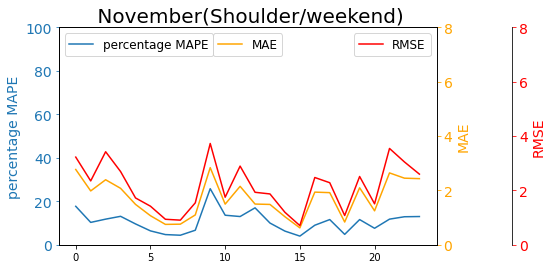

In [ ]:
#We plot the performance of the ARX model using the three different error metrics. 
# the evaluation metrics varie with the time of the day. 
# we set up the first axis (x:Hour_day , y: percentage MAPE )
fig, ax1 = plt.subplots()
fig.subplots_adjust(right=1)
p1, = ax1.plot(df_weekday['Hour_day'], df_weekday['percentage MAPE']) 
ax1.set_ylabel('percentage MAPE')

ax1.legend(['percentage MAPE'], loc="upper left",fontsize=12)
ax1.yaxis.label.set_color(p1.get_color())
ax1.yaxis.label.set_fontsize(14)
ax1.tick_params(axis='y', colors=p1.get_color(), labelsize=14)
ax1.set_ylim(0, 100)
ax2 = ax1.twinx() 
# we set up the second axis (x:Hour_day , y: MAE )
p2, = ax2.plot(df_weekday['Hour_day'], df_weekday['MAE'], color='orange')
ax2.grid(False) 
ax2.set_ylabel('MAE')
ax2.legend(['MAE'], loc="upper center",fontsize=12)
ax2.set_ylim(0, 8)
ax2.yaxis.label.set_color(p2.get_color())
ax2.yaxis.label.set_fontsize(14)
ax2.tick_params(axis='y', colors=p2.get_color(), labelsize=14)

#  we set up the third axis (x:Hour_day , y: RMSE )
ax3 = ax1.twinx()
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.20))
p3, = ax3.plot(df_weekday['Hour_day'], df_weekday['RMSE'], color='red')
ax3.set_ylim(0, 8)
ax3.grid(False) 
ax3.set_ylabel('RMSE')

ax3.legend(['RMSE'], loc="upper right",fontsize=12)
ax3.yaxis.label.set_color(p3.get_color())
ax3.yaxis.label.set_fontsize(14)
ax3.tick_params(axis='y', colors=p3.get_color(), labelsize=14)
plt.title(" November(Shoulder/weekend)",fontsize=20)
plt.show()


In [ ]:
#  Steps to evaluate the seasonal performance varation using the the histogram plot: 
# we display the monthly dataset  
F_month

,READ_DATE,Day,Day_month,Month,Year,Hour,Hour_day,Week_Day,Temperature,Irradiation.flux,...,Irradiation_flux_lag17,Irradiation_flux_lag18,Irradiation_flux_lag19,Irradiation_flux_lag20,Irradiation_flux_lag21,Irradiation_flux_lag22,Irradiation_flux_lag23,Irradiation_flux_lag24,yhat,resid
792,2019-02-04 00:00:00,35,4,2,2019,817,0,MON,0.4,0.4,...,3.6,3.4,3.4,3.4,3.4,3.4,3.3,2.2,20.63846,-1.73846
793,2019-02-04 01:00:00,35,4,2,2019,818,1,MON,0.0,0.4,...,5.4,3.6,3.4,3.4,3.4,3.4,3.4,3.3,20.464608,0.235392
794,2019-02-04 02:00:00,35,4,2,2019,819,2,MON,-0.3,0.4,...,11.1,5.4,3.6,3.4,3.4,3.4,3.4,3.4,20.261755,0.638245
795,2019-02-04 03:00:00,35,4,2,2019,820,3,MON,-0.3,1.2,...,25.9,11.1,5.4,3.6,3.4,3.4,3.4,3.4,20.170522,1.729478
796,2019-02-04 04:00:00,35,4,2,2019,821,4,MON,-0.4,1.4,...,26.2,25.9,11.1,5.4,3.6,3.4,3.4,3.4,20.670963,-0.470963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,2019-02-28 19:00:00,59,28,2,2019,1412,19,THU,0.6,0.2,...,1.4,1.3,0.9,0.2,0.1,0.0,0.1,0.0,19.869403,-1.859403
1388,2019-02-28 20:00:00,59,28,2,2019,1413,20,THU,-0.5,0.0,...,1.4,1.4,1.3,0.9,0.2,0.1,0.0,0.1,20.646546,2.153454
1389,2019-02-28 21:00:00,59,28,2,2019,1414,21,THU,-1.3,0.0,...,1.8,1.4,1.4,1.3,0.9,0.2,0.1,0.0,21.27282,-0.87282
1390,2019-02-28 22:00:00,59,28,2,2019,1415,22,THU,-2.0,0.1,...,2.1,1.8,1.4,1.4,1.3,0.9,0.2,0.1,21.624688,4.975312


In [ ]:
# we calculate the 10th and 90th percentile of the forecasting error. 
print("10% quantile =",np.percentile(F_month['resid'],10))
print("90% quantile =",np.percentile(F_month['resid'],90))

10% quantile = -2.32178276909732
90% quantile = 2.9664741085583244


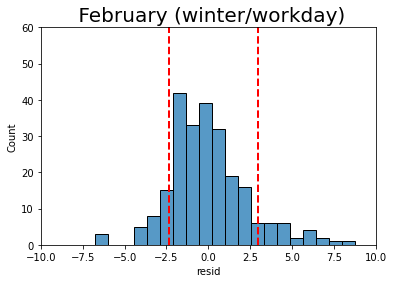

In [ ]:
# Creating the histogram of the forecasting errors
# the two line represent the quantiles (10% quantile and 90 % quantile)
sns.histplot(data=F_month, x="resid",log_scale=False, bins = 20)
plt.axvline(np.percentile(F_month['resid'],10), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(F_month['resid'],90), color='r', linestyle='dashed', linewidth=2)
plt.xlim(-10, 10)
plt.ylim(0, 60)
plt.title(" February (winter/workday)",fontsize=20)
plt.show()

In [ ]:
# In order to perform a summury of the hourly forecast error for each month we calculate: 
# the root mean square error (RMSE) 
# the mean error (ME)
# Error Quantiles

# Calculate RMSE 
MSE = np.square(np.subtract(F_month['POWER1'],F_month['yhat'])).mean() 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE) 

# we calculate the mean  error (ME)/ # the denominator represent the number of samples for each month 
ME = sum (F_month['resid'])/240
print("Mean error : " + str(ME))

# we calculate the 10th and 90th percentile of the forecasting error. 
print("10% quantile =",np.percentile(F_month['resid'],10))
print("90% quantile =",np.percentile(F_month['resid'],90))

# we calculate the 1th and 99th percentile of the forecasting error. 
print("1% quantile =",np.percentile(F_month['resid'],1))
print("99% quantile =",np.percentile(F_month['resid'],99))

Root Mean Square Error:

2.3391850074615688
Mean error : 0.009633938556007516
10% quantile = -2.32178276909732
90% quantile = 2.9664741085583244
1% quantile = -5.240428378474767
99% quantile = 6.595371394914216


In [ ]:
#@title Weekend Days


In [ ]:
#For the weekend days we repeat the same process before.
weekend_day_model=winter_model[(winter_model['Week_Day'] == 'SAT') | (winter_model['Week_Day'] == 'SUN')]


In [ ]:
# We split the dataset into training and testing data.
# we filter the dataset into odd and even days (the even days will represent the testing data  )
testing_data_weekend=weekend_day_model[weekend_day_model.Day_month % 2==0]


In [ ]:
# the odd days will represent the training data.
training_data_weekend=weekend_day_model[weekend_day_model.Day_month % 2==1]


In [ ]:
# we convert the  integers dummy variables (calendar data)  to floats. (training_data_weekend dataframe)
training_data_weekend[['Tuesday 0h','Tuesday 1h','Tuesday 2h','Tuesday 3h','Tuesday 4h','Tuesday 5h','Tuesday 6h','Tuesday 7h','Tuesday 8h','Tuesday 9h','Tuesday 10h','Tuesday 11h','Tuesday 12h','Tuesday 13h','Tuesday 14h',
        'Tuesday 15h','Tuesday 16h','Tuesday 17h','Tuesday 18h','Tuesday 19h','Tuesday 20h','Tuesday 21h','Tuesday 22h','Tuesday 23h','Wednesday 0h','Wednesday 1h','Wednesday 2h','Wednesday 3h','Wednesday 4h','Wednesday 5h','Wednesday 6h','Wednesday 7h','Wednesday 8h','Wednesday 9h','Wednesday 10h','Wednesday 11h','Wednesday 12h','Wednesday 13h','Wednesday 14h',
        'Wednesday 15h','Wednesday 16h','Wednesday 17h','Wednesday 18h','Wednesday 19h','Wednesday 20h','Wednesday 21h','Wednesday 22h','Wednesday 23h','Thursday 0h','Thursday 1h','Thursday 2h','Thursday 3h','Thursday 4h','Thursday 5h','Thursday 6h','Thursday 7h','Thursday 8h','Thursday 9h','Thursday 10h','Thursday 11h','Thursday 12h','Thursday 13h','Thursday 14h',
        'Thursday 15h','Thursday 16h','Thursday 17h','Thursday 18h','Thursday 19h','Thursday 20h','Thursday 21h','Thursday 22h','Thursday 23h','Friday 0h','Friday 1h','Friday 2h','Friday 3h','Friday 4h','Friday 5h','Friday 6h','Friday 7h','Friday 8h','Friday 9h','Friday 10h','Friday 11h','Friday 12h','Friday 13h','Friday 14h',
        'Friday 15h','Friday 16h','Friday 17h','Friday 18h','Friday 19h','Friday 20h','Friday 21h','Friday 22h','Friday 23h','Saturday 0h','Saturday 1h','Saturday 2h','Saturday 3h','Saturday 4h','Saturday 5h','Saturday 6h','Saturday 7h','Saturday 8h','Saturday 9h','Saturday 10h','Saturday 11h','Saturday 12h','Saturday 13h','Saturday 14h',
        'Saturday 15h','Saturday 16h','Saturday 17h','Saturday 18h','Saturday 19h','Saturday 20h','Saturday 21h','Saturday 22h','Saturday 23h','Sunday 0h','Sunday 1h','Sunday 2h','Sunday 3h','Sunday 4h','Sunday 5h','Sunday 6h','Sunday 7h','Sunday 8h','Sunday 9h','Sunday 10h','Sunday 11h','Sunday 12h','Sunday 13h','Sunday 14h',
        'Sunday 15h','Sunday 16h','Sunday 17h','Sunday 18h','Sunday 19h','Sunday 20h','Sunday 21h','Sunday 22h','Sunday 23h','Monday 0h','Monday 1h','Monday 2h','Monday 3h','Monday 4h','Monday 5h','Monday 6h','Monday 7h','Monday 8h','Monday 9h','Monday 10h','Monday 11h','Monday 12h','Monday 13h','Monday 14h',
        'Monday 15h','Monday 16h','Monday 17h','Monday 18h','Monday 19h','Monday 20h','Monday 21h','Monday 22h','Monday 23h']]= training_data_weekend[['Tuesday 0h','Tuesday 1h','Tuesday 2h','Tuesday 3h','Tuesday 4h','Tuesday 5h','Tuesday 6h','Tuesday 7h','Tuesday 8h','Tuesday 9h','Tuesday 10h','Tuesday 11h','Tuesday 12h','Tuesday 13h','Tuesday 14h',
        'Tuesday 15h','Tuesday 16h','Tuesday 17h','Tuesday 18h','Tuesday 19h','Tuesday 20h','Tuesday 21h','Tuesday 22h','Tuesday 23h','Wednesday 0h','Wednesday 1h','Wednesday 2h','Wednesday 3h','Wednesday 4h','Wednesday 5h','Wednesday 6h','Wednesday 7h','Wednesday 8h','Wednesday 9h','Wednesday 10h','Wednesday 11h','Wednesday 12h','Wednesday 13h','Wednesday 14h',
        'Wednesday 15h','Wednesday 16h','Wednesday 17h','Wednesday 18h','Wednesday 19h','Wednesday 20h','Wednesday 21h','Wednesday 22h','Wednesday 23h','Thursday 0h','Thursday 1h','Thursday 2h','Thursday 3h','Thursday 4h','Thursday 5h','Thursday 6h','Thursday 7h','Thursday 8h','Thursday 9h','Thursday 10h','Thursday 11h','Thursday 12h','Thursday 13h','Thursday 14h',
        'Thursday 15h','Thursday 16h','Thursday 17h','Thursday 18h','Thursday 19h','Thursday 20h','Thursday 21h','Thursday 22h','Thursday 23h','Friday 0h','Friday 1h','Friday 2h','Friday 3h','Friday 4h','Friday 5h','Friday 6h','Friday 7h','Friday 8h','Friday 9h','Friday 10h','Friday 11h','Friday 12h','Friday 13h','Friday 14h',
        'Friday 15h','Friday 16h','Friday 17h','Friday 18h','Friday 19h','Friday 20h','Friday 21h','Friday 22h','Friday 23h','Saturday 0h','Saturday 1h','Saturday 2h','Saturday 3h','Saturday 4h','Saturday 5h','Saturday 6h','Saturday 7h','Saturday 8h','Saturday 9h','Saturday 10h','Saturday 11h','Saturday 12h','Saturday 13h','Saturday 14h',
        'Saturday 15h','Saturday 16h','Saturday 17h','Saturday 18h','Saturday 19h','Saturday 20h','Saturday 21h','Saturday 22h','Saturday 23h','Sunday 0h','Sunday 1h','Sunday 2h','Sunday 3h','Sunday 4h','Sunday 5h','Sunday 6h','Sunday 7h','Sunday 8h','Sunday 9h','Sunday 10h','Sunday 11h','Sunday 12h','Sunday 13h','Sunday 14h',
        'Sunday 15h','Sunday 16h','Sunday 17h','Sunday 18h','Sunday 19h','Sunday 20h','Sunday 21h','Sunday 22h','Sunday 23h','Monday 0h','Monday 1h','Monday 2h','Monday 3h','Monday 4h','Monday 5h','Monday 6h','Monday 7h','Monday 8h','Monday 9h','Monday 10h','Monday 11h','Monday 12h','Monday 13h','Monday 14h',
        'Monday 15h','Monday 16h','Monday 17h','Monday 18h','Monday 19h','Monday 20h','Monday 21h','Monday 22h','Monday 23h']].apply(pd.to_numeric,downcast='float')


training_data_weekend.dtypes


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


READ_DATE                 datetime64[ns]
Day                                int64
Day_month                          int64
Month                              int64
Year                               int64
                               ...      
Irradiation.flux_lag20           float64
Irradiation.flux_lag21           float64
Irradiation.flux_lag22           float64
Irradiation.flux_lag23           float64
Irradiation.flux_lag24           float64
Length: 244, dtype: object

In [ ]:
# we convert the  integers dummy variables (calendar data)  to floats. (testing_data_weekend dataframe)
testing_data_weekend[['Tuesday 0h','Tuesday 1h','Tuesday 2h','Tuesday 3h','Tuesday 4h','Tuesday 5h','Tuesday 6h','Tuesday 7h','Tuesday 8h','Tuesday 9h','Tuesday 10h','Tuesday 11h','Tuesday 12h','Tuesday 13h','Tuesday 14h',
        'Tuesday 15h','Tuesday 16h','Tuesday 17h','Tuesday 18h','Tuesday 19h','Tuesday 20h','Tuesday 21h','Tuesday 22h','Tuesday 23h','Wednesday 0h','Wednesday 1h','Wednesday 2h','Wednesday 3h','Wednesday 4h','Wednesday 5h','Wednesday 6h','Wednesday 7h','Wednesday 8h','Wednesday 9h','Wednesday 10h','Wednesday 11h','Wednesday 12h','Wednesday 13h','Wednesday 14h',
        'Wednesday 15h','Wednesday 16h','Wednesday 17h','Wednesday 18h','Wednesday 19h','Wednesday 20h','Wednesday 21h','Wednesday 22h','Wednesday 23h','Thursday 0h','Thursday 1h','Thursday 2h','Thursday 3h','Thursday 4h','Thursday 5h','Thursday 6h','Thursday 7h','Thursday 8h','Thursday 9h','Thursday 10h','Thursday 11h','Thursday 12h','Thursday 13h','Thursday 14h',
        'Thursday 15h','Thursday 16h','Thursday 17h','Thursday 18h','Thursday 19h','Thursday 20h','Thursday 21h','Thursday 22h','Thursday 23h','Friday 0h','Friday 1h','Friday 2h','Friday 3h','Friday 4h','Friday 5h','Friday 6h','Friday 7h','Friday 8h','Friday 9h','Friday 10h','Friday 11h','Friday 12h','Friday 13h','Friday 14h',
        'Friday 15h','Friday 16h','Friday 17h','Friday 18h','Friday 19h','Friday 20h','Friday 21h','Friday 22h','Friday 23h','Saturday 0h','Saturday 1h','Saturday 2h','Saturday 3h','Saturday 4h','Saturday 5h','Saturday 6h','Saturday 7h','Saturday 8h','Saturday 9h','Saturday 10h','Saturday 11h','Saturday 12h','Saturday 13h','Saturday 14h',
        'Saturday 15h','Saturday 16h','Saturday 17h','Saturday 18h','Saturday 19h','Saturday 20h','Saturday 21h','Saturday 22h','Saturday 23h','Sunday 0h','Sunday 1h','Sunday 2h','Sunday 3h','Sunday 4h','Sunday 5h','Sunday 6h','Sunday 7h','Sunday 8h','Sunday 9h','Sunday 10h','Sunday 11h','Sunday 12h','Sunday 13h','Sunday 14h',
        'Sunday 15h','Sunday 16h','Sunday 17h','Sunday 18h','Sunday 19h','Sunday 20h','Sunday 21h','Sunday 22h','Sunday 23h','Monday 0h','Monday 1h','Monday 2h','Monday 3h','Monday 4h','Monday 5h','Monday 6h','Monday 7h','Monday 8h','Monday 9h','Monday 10h','Monday 11h','Monday 12h','Monday 13h','Monday 14h',
        'Monday 15h','Monday 16h','Monday 17h','Monday 18h','Monday 19h','Monday 20h','Monday 21h','Monday 22h','Monday 23h']]= testing_data_weekend[['Tuesday 0h','Tuesday 1h','Tuesday 2h','Tuesday 3h','Tuesday 4h','Tuesday 5h','Tuesday 6h','Tuesday 7h','Tuesday 8h','Tuesday 9h','Tuesday 10h','Tuesday 11h','Tuesday 12h','Tuesday 13h','Tuesday 14h',
        'Tuesday 15h','Tuesday 16h','Tuesday 17h','Tuesday 18h','Tuesday 19h','Tuesday 20h','Tuesday 21h','Tuesday 22h','Tuesday 23h','Wednesday 0h','Wednesday 1h','Wednesday 2h','Wednesday 3h','Wednesday 4h','Wednesday 5h','Wednesday 6h','Wednesday 7h','Wednesday 8h','Wednesday 9h','Wednesday 10h','Wednesday 11h','Wednesday 12h','Wednesday 13h','Wednesday 14h',
        'Wednesday 15h','Wednesday 16h','Wednesday 17h','Wednesday 18h','Wednesday 19h','Wednesday 20h','Wednesday 21h','Wednesday 22h','Wednesday 23h','Thursday 0h','Thursday 1h','Thursday 2h','Thursday 3h','Thursday 4h','Thursday 5h','Thursday 6h','Thursday 7h','Thursday 8h','Thursday 9h','Thursday 10h','Thursday 11h','Thursday 12h','Thursday 13h','Thursday 14h',
        'Thursday 15h','Thursday 16h','Thursday 17h','Thursday 18h','Thursday 19h','Thursday 20h','Thursday 21h','Thursday 22h','Thursday 23h','Friday 0h','Friday 1h','Friday 2h','Friday 3h','Friday 4h','Friday 5h','Friday 6h','Friday 7h','Friday 8h','Friday 9h','Friday 10h','Friday 11h','Friday 12h','Friday 13h','Friday 14h',
        'Friday 15h','Friday 16h','Friday 17h','Friday 18h','Friday 19h','Friday 20h','Friday 21h','Friday 22h','Friday 23h','Saturday 0h','Saturday 1h','Saturday 2h','Saturday 3h','Saturday 4h','Saturday 5h','Saturday 6h','Saturday 7h','Saturday 8h','Saturday 9h','Saturday 10h','Saturday 11h','Saturday 12h','Saturday 13h','Saturday 14h',
        'Saturday 15h','Saturday 16h','Saturday 17h','Saturday 18h','Saturday 19h','Saturday 20h','Saturday 21h','Saturday 22h','Saturday 23h','Sunday 0h','Sunday 1h','Sunday 2h','Sunday 3h','Sunday 4h','Sunday 5h','Sunday 6h','Sunday 7h','Sunday 8h','Sunday 9h','Sunday 10h','Sunday 11h','Sunday 12h','Sunday 13h','Sunday 14h',
        'Sunday 15h','Sunday 16h','Sunday 17h','Sunday 18h','Sunday 19h','Sunday 20h','Sunday 21h','Sunday 22h','Sunday 23h','Monday 0h','Monday 1h','Monday 2h','Monday 3h','Monday 4h','Monday 5h','Monday 6h','Monday 7h','Monday 8h','Monday 9h','Monday 10h','Monday 11h','Monday 12h','Monday 13h','Monday 14h',
        'Monday 15h','Monday 16h','Monday 17h','Monday 18h','Monday 19h','Monday 20h','Monday 21h','Monday 22h','Monday 23h']].apply(pd.to_numeric,downcast='float')


testing_data_weekend.dtypes

READ_DATE                 datetime64[ns]
Day                                int64
Day_month                          int64
Month                              int64
Year                               int64
                               ...      
Irradiation.flux_lag20           float64
Irradiation.flux_lag21           float64
Irradiation.flux_lag22           float64
Irradiation.flux_lag23           float64
Irradiation.flux_lag24           float64
Length: 244, dtype: object

In [ ]:
#@title ARX model (Weekend Days)


In [ ]:
#Separation of indeppendent variables and dependent variables

import pandas as pd
import statsmodels.api as sm
X = training_data_weekend[['POWER1_lag1','Temperature_lag0','Temperature_lag1','Irradiation.flux_lag0','Irradiation.flux_lag1','Sunday 5h','Saturday 2h','Saturday 10h','Sunday 1h']] 
Y = training_data_weekend['POWER1_lag0']

In [ ]:
# we fit our model using the ols method . 
import pandas as pd
import statsmodels.api as sm
from sklearn import linear_model
import statsmodels.formula.api as smf
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
print_model = model.summary()
print(print_model)

In [ ]:
#@title  Data Scenarios and Model optimization to predict the heat   load (weekends) 

In [ ]:
# We evaluate the performance of models using the three different data scenarios

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
F1=testing_data_weekend.rename(columns={'Saturday 0h':'Saturday_0h','Saturday 1h':'Saturday_1h','Saturday 2h':'Saturday_2h','Saturday 3h':'Saturday_3h','Saturday 4h':'Saturday_4h','Saturday 5h':'Saturday_5h','Saturday 6h':'Saturday_6h','Saturday 7h':'Saturday_7h','Saturday 8h':'Saturday_8h','Saturday 9h':'Saturday_9h','Saturday 10h':'Saturday_10h','Saturday 11h':'Saturday_11h','Saturday 12h':'Saturday_12h','Saturday 13h':'Saturday_13h','Saturday 14h':'Saturday_14h',
'Saturday 15h':'Saturday_15h','Saturday 16h':'Saturday_16h','Saturday 17h':'Saturday_17h','Saturday 18h':'Saturday_18h','Saturday 19h':'Saturday_19h','Saturday 20h':'Saturday_20h','Saturday 21h':'Saturday_21h','Saturday 22h':'Saturday_22h','Saturday 23h':'Saturday_23h','Sunday 0h':'Sunday_0h','Sunday 1h':'Sunday_1h','Sunday 2h':'Sunday_2h','Sunday 3h':'Sunday_3h','Sunday 4h':'Sunday_4h','Sunday 5h':'Sunday_5h','Sunday 6h':'Sunday_6h','Sunday 7h':'Sunday_7h','Sunday 8h':'Sunday_8h','Sunday 9h':'Sunday_9h','Sunday 10h':'Sunday_10h','Sunday 11h':'Sunday_11h','Sunday 12h':'Sunday_12h','Sunday 13h':'Sunday_13h','Sunday 14h':'Sunday_14h',
'Sunday 15h':'Sunday_15h','Sunday 16h':'Sunday_16h','Sunday 17h':'Sunday_17h','Sunday 18h':'Sunday_18h','Sunday 19h':'Sunday_19h','Sunday 20h':'Sunday_20h','Sunday 21h':'Sunday_21h','Sunday 22h':'Sunday_22h','Sunday 23h':'Sunday_23h','Irradiation.flux_lag0':'Irradiation_flux_lag0','Irradiation.flux_lag1':'Irradiation_flux_lag1','Irradiation.flux_lag2':'Irradiation_flux_lag2','Irradiation.flux_lag3':'Irradiation_flux_lag3','Irradiation.flux_lag4':'Irradiation_flux_lag4','Irradiation.flux_lag5':'Irradiation_flux_lag5','Irradiation.flux_lag6':'Irradiation_flux_lag6','Irradiation.flux_lag7':'Irradiation_flux_lag7','Irradiation.flux_lag8':'Irradiation_flux_lag8','Irradiation.flux_lag9':'Irradiation_flux_lag9','Irradiation.flux_lag10':'Irradiation_flux_lag10',
'Irradiation.flux_lag11':'Irradiation_flux_lag11','Irradiation.flux_lag12':'Irradiation_flux_lag12','Irradiation.flux_lag13':'Irradiation_flux_lag13','Irradiation.flux_lag14':'Irradiation_flux_lag14','Irradiation.flux_lag15':'Irradiation_flux_lag15','Irradiation.flux_lag16':'Irradiation_flux_lag16','Irradiation.flux_lag17':'Irradiation_flux_lag17','Irradiation.flux_lag18':'Irradiation_flux_lag18','Irradiation.flux_lag19':'Irradiation_flux_lag19','Irradiation.flux_lag20':'Irradiation_flux_lag20','Irradiation.flux_lag21':'Irradiation_flux_lag21','Irradiation.flux_lag22':'Irradiation_flux_lag22','Irradiation.flux_lag23':'Irradiation_flux_lag23','Irradiation.flux_lag24':'Irradiation_flux_lag24','Bank Holidays':'Bank_Holidays'})
#We include various types of input parameters, different data scenario have been created to the weekends model  
KJB = smf.ols('POWER1_lag0 ~ POWER1_lag1 + Temperature_lag0 + Temperature_lag1 + Irradiation_flux_lag0 + Irradiation_flux_lag1 + Saturday_2h + Saturday_10h + Sunday_1h + Sunday_4h + Sunday_5h',F1).fit()
#we add two columns (predicted values + residual values) to the dataframe (testing data) in order to use them later when see the quality of our model .
F1['yhat'] = KJB.fittedvalues
F1['resid'] = KJB.resid
F1['predicted'] = KJB.predict(F1)
F1.loc[:,'predicted'] =  KJB.predict(F1)




In [ ]:
# we calculate the MAE metric for the testing data for each data scenario 
# we calculate the RMSE for the testing data for each data scenario
#We import the mean_absolute_error from the module sklearn.metrics of sklearn library.
import math
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
# we calculate  mean absolute error (MAE) 
error = mae(F1['POWER1_lag0'], F1['predicted'])
# We print the value of MAE and RMSE
print("Mean absolute error : " + str(error))
MSE = np.square(np.subtract(F1['POWER1_lag0'],F1['predicted'])).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)
# We print the value of MAPE 


Mean absolute error : 1.987089544863697
Root Mean Square Error:

2.712091510124934


In [ ]:
#@title Seasonal Performance Variations (weekends)

In [ ]:
# We evaluate the performance of the model in each month, where the forecast error varies with time of the days

In [ ]:
#We remove the duplicate from the datatset
F1 =F1.T.drop_duplicates().T
F1_month=F1[(F1['Month'] == 2)]
F1_month =F1_month.T.drop_duplicates().T
F1_hours=F1_month[(F1['Hour_day'] == 23)]
F1_hours =F1_hours.T.drop_duplicates().T

<ipython-input-66-e724fedb4fd3>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  F1_hours=F1_month[(F1['Hour_day'] == 23)]


In [ ]:
# we calculate  mean absolute error (MAE) 
error = mae(F1_hours['POWER1'], F1_hours['yhat'])
# We print the value of MAE and RMSE
print("Mean absolute error : " + str(error))
MSE = np.square(np.subtract(F1_hours['POWER1'],F1_hours['yhat'])).mean() 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)
from sklearn.metrics import mean_absolute_percentage_error
# We print the value of MAPE
MAPE = mean_absolute_percentage_error(F1_hours['POWER1'], F1_hours['yhat'])
print("Mean absolute percentage error :\n")
print(MAPE)

Mean absolute error : 2.393834830253379
Root Mean Square Error:

2.7218384986472612
Mean absolute percentage error :

0.11511677897907152


In [ ]:
#We upload the seasonal performance variations file ( In this file we collect the evaluation metrics of  all the selected models in each month, 
#where the forecast error varies with time of the days)
#The evaluation metric data in this file are both for winter and shoulder term.
# We upload the seasonal performance variations file
from google.colab import files
uploaded = files.upload()

Saving seasonal performance variation.xlsx to seasonal performance variation (2).xlsx


In [ ]:
# Convert the excel file into pandas Dataframe
import io
dk = pd.read_excel(io.BytesIO(uploaded['seasonal performance variation.xlsx']))
dk

,Hour_day,seasonal_term,type_day,Month,MAE,RMSE,MAPE
0,0,Winter,workday,December,1.388,1.829,0.083
1,1,Winter,workday,December,2.292,2.527,0.135
2,2,Winter,workday,December,1.365,1.527,0.083
3,3,Winter,workday,December,1.333,1.602,0.079
4,4,Winter,workday,December,1.474,1.803,0.089
...,...,...,...,...,...,...,...
427,19,Shoulder,weekend,november,2.098,2.513,0.116
428,20,Shoulder,weekend,november,1.250,1.508,0.076
429,21,Shoulder,weekend,november,2.645,3.545,0.118
430,22,Shoulder,weekend,november,2.451,3.048,0.129


In [ ]:
#we filter the dataframe by month , season and type of the week 
df_month= dk[(dk['Month'] == 'February' )]
df_season=df_month[(df_month['seasonal_term'] == 'Winter')]
df_weekday= df_month[(df_month['type_day'] == 'weekend')]
df_weekday


,Hour_day,seasonal_term,type_day,Month,MAE,RMSE,MAPE
120,0,Winter,weekend,February,1.732,2.178,0.084
121,1,Winter,weekend,February,2.393,2.877,0.112
122,2,Winter,weekend,February,1.170,1.270,0.062
123,3,Winter,weekend,February,1.402,1.519,0.068
124,4,Winter,weekend,February,1.174,1.346,0.062
125,5,Winter,weekend,February,1.336,1.497,0.072
126,6,Winter,weekend,February,0.431,0.465,0.022
127,7,Winter,weekend,February,2.198,2.567,0.104
128,8,Winter,weekend,February,1.491,1.897,0.070
129,9,Winter,weekend,February,1.428,1.653,0.078


In [ ]:
# we convert the MAPE value to percentage
df_weekday['percentage MAPE'] = df_weekday['MAPE'] * 100
df_weekday

<ipython-input-71-8382dff704b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekday['percentage MAPE'] = df_weekday['MAPE'] * 100


,Hour_day,seasonal_term,type_day,Month,MAE,RMSE,MAPE,percentage MAPE
120,0,Winter,weekend,February,1.732,2.178,0.084,8.4
121,1,Winter,weekend,February,2.393,2.877,0.112,11.2
122,2,Winter,weekend,February,1.170,1.270,0.062,6.2
123,3,Winter,weekend,February,1.402,1.519,0.068,6.8
124,4,Winter,weekend,February,1.174,1.346,0.062,6.2
125,5,Winter,weekend,February,1.336,1.497,0.072,7.2
126,6,Winter,weekend,February,0.431,0.465,0.022,2.2
127,7,Winter,weekend,February,2.198,2.567,0.104,10.4
128,8,Winter,weekend,February,1.491,1.897,0.070,7.0
129,9,Winter,weekend,February,1.428,1.653,0.078,7.8


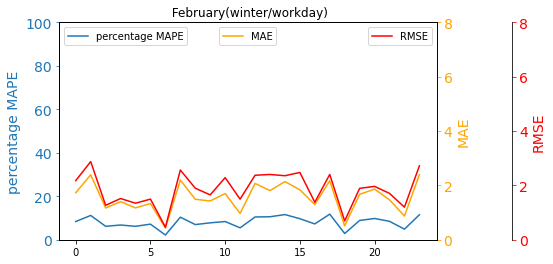

In [ ]:
#We plot the performance of the ARX model using the three different error metrics. 
# the evaluation metrics varie with the time of the day. 
# we set up the first axis (x:Hour_day , y: percentage MAPE )
fig, ax1 = plt.subplots()
fig.subplots_adjust(right=1)
p1, = ax1.plot(df_weekday['Hour_day'], df_weekday['percentage MAPE']) 
ax1.set_ylabel('percentage MAPE')

ax1.legend(['percentage MAPE'], loc="upper left")
ax1.yaxis.label.set_color(p1.get_color())
ax1.yaxis.label.set_fontsize(14)
ax1.tick_params(axis='y', colors=p1.get_color(), labelsize=14)
ax1.set_ylim(0, 100)
ax2 = ax1.twinx() 
# we set up the second axis (x:Hour_day , y: MAE )
p2, = ax2.plot(df_weekday['Hour_day'], df_weekday['MAE'], color='orange')
ax2.grid(False) 
ax2.set_ylabel('MAE')
ax2.legend(['MAE'], loc="upper center")
ax2.set_ylim(0, 8)
ax2.yaxis.label.set_color(p2.get_color())
ax2.yaxis.label.set_fontsize(14)
ax2.tick_params(axis='y', colors=p2.get_color(), labelsize=14)

#  we set up the third axis (x:Hour_day , y: RMSE )
ax3 = ax1.twinx()
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.20))
p3, = ax3.plot(df_weekday['Hour_day'], df_weekday['RMSE'], color='red')
ax3.set_ylim(0, 8)
ax3.grid(False) 
ax3.set_ylabel('RMSE')

ax3.legend(['RMSE'], loc="upper right")
ax3.yaxis.label.set_color(p3.get_color())
ax3.yaxis.label.set_fontsize(14)
ax3.tick_params(axis='y', colors=p3.get_color(), labelsize=14)
plt.title(" February(winter/workday)")
plt.show()


In [ ]:
#  Steps to evaluate the seasonal performance varation using the the histogram plot: 
# we display the monthly dataset  
F1_month

,READ_DATE,Day,Day_month,Month,Year,Hour,Hour_day,Week_Day,Temperature,Irradiation.flux,...,Irradiation_flux_lag17,Irradiation_flux_lag18,Irradiation_flux_lag19,Irradiation_flux_lag20,Irradiation_flux_lag21,Irradiation_flux_lag22,Irradiation_flux_lag23,Irradiation_flux_lag24,yhat,resid
744,2019-02-02 00:00:00,33,2,2,2019,769,0,SAT,-1.7,1.0,...,1.2,1.5,1.8,1.6,1.8,1.7,1.6,1.7,21.674112,3.625888
745,2019-02-02 01:00:00,33,2,2,2019,770,1,SAT,-1.6,1.0,...,3.6,1.2,1.5,1.8,1.6,1.8,1.7,1.6,23.073929,0.626071
746,2019-02-02 02:00:00,33,2,2,2019,771,2,SAT,-1.5,1.4,...,16.0,3.6,1.2,1.5,1.8,1.6,1.8,1.7,22.196629,-1.796629
747,2019-02-02 03:00:00,33,2,2,2019,772,3,SAT,-1.4,1.9,...,40.6,16.0,3.6,1.2,1.5,1.8,1.6,1.8,21.500668,1.699332
748,2019-02-02 04:00:00,33,2,2,2019,773,4,SAT,-1.3,1.5,...,65.6,40.6,16.0,3.6,1.2,1.5,1.8,1.6,22.242911,-1.342911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,2019-02-24 19:00:00,55,24,2,2019,1316,19,SUN,2.1,1.9,...,3.4,3.4,3.4,2.0,1.2,1.0,1.0,2.3,18.428258,-0.728258
1292,2019-02-24 20:00:00,55,24,2,2019,1317,20,SUN,2.3,1.7,...,4.0,3.4,3.4,3.4,2.0,1.2,1.0,1.0,17.95636,1.44364
1293,2019-02-24 21:00:00,55,24,2,2019,1318,21,SUN,1.8,0.4,...,4.1,4.0,3.4,3.4,3.4,2.0,1.2,1.0,18.487814,-0.087814
1294,2019-02-24 22:00:00,55,24,2,2019,1319,22,SUN,1.7,0.2,...,4.1,4.1,4.0,3.4,3.4,3.4,2.0,1.2,18.466586,-0.166586


In [ ]:
# we calculate the 10th and 90th percentile of the forecasting error. 
print("10% quantile =",np.percentile(F1_month['resid'],10))
print("90% quantile =",np.percentile(F1_month['resid'],90))

10% quantile = -1.7719383706184129
90% quantile = 3.5508348412930353


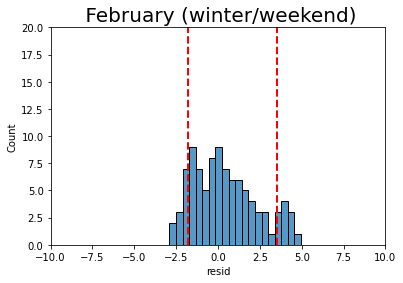

In [ ]:
# Creating the histogram of the forecasting errors
# the two line represent the quantiles (10% quantile and 90 % quantile)
sns.histplot(data=F1_month, x="resid",log_scale=False, bins = 20)
plt.axvline(np.percentile(F1_month['resid'],10), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(F1_month['resid'],90), color='r', linestyle='dashed', linewidth=2)
plt.xlim(-10, 10)
plt.ylim(0, 20)
plt.title(" February (winter/weekend)",fontsize=20)
plt.show()

In [ ]:
# In order to perform a summury of the hourly forecast error for each month we calculate: 
# the root mean square error (RMSE) 
# the mean error (ME)
# Error Quantiles

# Calculate RMSE 
MSE = np.square(np.subtract(F1_month['POWER1'],F1_month['yhat'])).mean() 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE) 

# we calculate the mean  error (ME)/ # the denominator represent the number of samples for each month 
ME = sum (F1_month['resid'])/122 
print("Mean error : " + str(ME))

# we calculate the 10th and 90th percentile of the forecasting error. 
print("10% quantile =",np.percentile(F1_month['resid'],10))
print("90% quantile =",np.percentile(F1_month['resid'],90))

# we calculate the 1th and 99th percentile of the forecasting error. 
print("1% quantile =",np.percentile(F1_month['resid'],1))
print("99% quantile =",np.percentile(F1_month['resid'],99))

Root Mean Square Error:

1.9592689189982704
Mean error : 0.3419129752884379
10% quantile = -1.7719383706184129
90% quantile = 3.5508348412930353
1% quantile = -2.6019990051004136
99% quantile = 4.424366488916192
